In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, make_scorer
from sklearn.pipeline import make_pipeline
import os

from ucimlrepo import fetch_ucirepo

In [66]:
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

# Functions
- Data Processing Functions
- Model Evaluation Functions
- Visualization Functions

## Data Processing Functions
- load_data()
- get_test_and_training_data(test_size=0.2)

In [214]:
## groups are right now 'Nacionality' and 'Gender'
def load_data():
    predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
    df = predict_students_dropout_and_academic_success.data.features

    data_y = predict_students_dropout_and_academic_success.data.targets
    data_y = data_y.Target.apply(lambda x: 1 if x == 'Dropout' else 0)

    df['Dropout'] = data_y
    df_incl_curricular_units = df.copy()

    ## Remove Features related to Curricular units
    df = df[['Marital Status', 'Application mode', 'Application order', 'Course',
           'Daytime/evening attendance', 'Previous qualification',
           'Previous qualification (grade)',
           'Admission grade', 'Displaced', 'Educational special needs', 'Debtor',
           'Tuition fees up to date',
           'International', 'Unemployment rate',
           'Inflation rate', 'GDP',
           "Mother's qualification", "Father's qualification",
           "Mother's occupation", "Father's occupation",
           'Scholarship holder', 'Age at enrollment', 'Nacionality', 'Gender', 'Dropout']]


    #S Insert mother_upper_class and father_upper_class
    df['mother_upper_class'] = 0
    df['father_upper_class'] = 0

    # TODO: check these idx
    mother_upper_class_occupation = [
        1, 2, 122, 123, 125, 131, 132, 134, 141, 143, 144, 153, 173
    ]
    father_upper_class_occupations = [
        1, 2, 101, 112, 114, 121, 122, 123, 124, 131, 132, 134, 135, 141,
        143, 144, 151, 152, 153, 154, 161, 171, 172, 174, 175, 181, 182
    ]

    df.loc[df["Mother's occupation"].isin(mother_upper_class_occupation), 'mother_upper_class'] = 1
    df.loc[df["Father's occupation"].isin(father_upper_class_occupations), 'father_upper_class'] = 1

    df_class = df.copy()

    # Remove "Mother's occupation" and "Father's occupation" columns
    df.drop(columns=["Mother's occupation", "Father's occupation"], inplace=True)

    protected_cols = ['Gender', 'mother_upper_class'] # TODO: add 'father_upper_class' and do something with parents qualitifcation

    features = df.drop('Dropout', axis=1)
    labels = df[['Dropout']]
    groups = df[protected_cols]

    features_init = features.copy()

    df_protected = pd.concat([df[x] for x in protected_cols], axis=1)
    for x in protected_cols:
      features = features.drop(x, axis=1)

    print(features.columns)


    return df, features_init, labels, groups, df_incl_curricular_units, features, df_class

def get_test_and_training_data(features, labels, test_size=0.2):
    ## This code is adapted from solution to data debias exercises
    X = features.copy()
    y = labels.copy()

    # X_train = X_train.reset_index(drop=True) # doesn't seem to make a difference now
    # y_train = y_train.reset_index(drop=True) # doesn't seem to make a difference now

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    # Subset for protected and non-protected features
    X_train_p = X_train.iloc[:, -2:]
    X_train_np = X_train.iloc[:, :-2]
    X_test_p = X_train.iloc[:, -2:]
    X_test_np = X_train.iloc[:, :-2]

    return X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np


## Model Evaluation Functions
- cross_validator
- fairness metrics

In [206]:
def cross_validator(X, y, n=5):
    ''' Input:  X: training data
                y: true labels
                n: number of folds for cross validation, default=5
        Output: 2 dataframes, with accuracy and f1 scores,
                per fold for overall and the 4 groups:
                male, female, white, african-american'''
    scaler = StandardScaler() ## We need to scale within the cross val step to avoid data leakage
    cls = LogisticRegression(penalty=None, max_iter=1000, random_state=seed)

    kfold = KFold(n, shuffle=True, random_state=seed)

    X_np = X.iloc[:, :-2]
    X_p = X.iloc[:, -2:]

    accuracies = []
    f1 = []
    X = np.array(X_np).reshape(-1, X_np.shape[1])
    X_p=np.array(X_p).reshape(-1, X_p.shape[1])
    y = np.array(y).reshape(-1, 1)

    for train_idx, test_idx in kfold.split(X):
        pipe = make_pipeline(scaler, cls)
        acc = []
        f1s = []
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test  = X[test_idx]
        y_test  = y[test_idx]
        X_p_test= X_p[test_idx]

        pipe.fit(X_train, y_train.ravel())
        y_hat = pipe.predict(X_test)

        acc.append(accuracy_score(y_test, y_hat))
        f1s.append(f1_score(y_test, y_hat))

        for i in [0,1]:
            for j in [0,1]:
                acc.append(accuracy_score(y_test[X_p_test[:,i]==j], y_hat[X_p_test[:,i]==j]))
                f1s.append(f1_score(y_test[X_p_test[:,i]==j], y_hat[X_p_test[:,i]==j]))
        accuracies.append(acc)
        f1.append(f1s)

    # TODO: find the order of m_upperclass or lower class? and it may be better to give it as an argument??
    return pd.DataFrame(accuracies, columns=['General','Male','Female','m_upper_class','m_lower_class']),\
           pd.DataFrame(f1, columns=['General','Male','Female','m_upper_class','m_lower_class'])


### Fairness Metrics

In [219]:
# Based on lecture 3
def group_idx(group_test):
  group_one_idx = [1 for _ in range(len(group_test))]
  group_two_idx = [0 for _ in range(len(group_test))]
  return group_one_idx, group_two_idx

def statistical_parity(y_hat, group_test):
  group_one_idx, group_two_idx = group_idx()
  one_select = np.mean(y_hat[(group_test == group_one_idx).flatten()]) # Calculate Pr(S=1 | G=1)
  two_select = np.mean(y_hat[(group_test == group_two_idx).flatten()]) # Calculate Pr(S=1 | G=0)
  statistical_parity = one_select == two_select
  return (statistical_parity, two_select, one_select)

def equalized_odds(y_hat, y_test, group_test):
  group_one_idx, group_two_idx = group_idx()

  one_tpr_0 = np.mean(y_hat[(y_test == 0) & (group_test == group_one_idx).flatten()])
  two_tpr_0 = np.mean(y_hat[(y_test == 0) & (group_test == group_two_idx).flatten()])
  one_tpr_1 = np.mean(y_hat[(y_test == 1) & (group_test == group_one_idx).flatten()])
  two_tpr_1 = np.mean(y_hat[(y_test == 1) & (group_test == group_two_idx).flatten()])

  equalized_odds = ((one_tpr_0 == two_tpr_0), (one_tpr_1 == two_tpr_1))
  return (equalized_odds, (two_tpr_0, one_tpr_0), (two_tpr_1, one_tpr_1))


def equal_outcome(y_hat, y_test, group_test):
  group_one_idx, group_two_idx = group_idx()
  one_ppr_0 = np.mean(y_test[(y_hat == 0) & (group_test == group_one_idx).flatten()])
  two_ppr_0 = np.mean(y_test[(y_hat == 0) & (group_test == group_two_idx).flatten()])
  one_ppr_1 = np.mean(y_test[(y_hat == 1) & (group_test == group_one_idx).flatten()])
  two_ppr_1 = np.mean(y_test[(y_hat == 1) & (group_test == group_two_idx).flatten()])

  fpr = one_ppr_0 == two_ppr_0
  tpr = one_ppr_1 == two_ppr_1
  equalized_outcome = (fpr, tpr)
  return (equalized_outcome, (two_ppr_0, one_ppr_0), (two_ppr_1, one_ppr_1)) # first s=0, then s=1


## Visualization Functions
- corr_mat(X, method='pearson')
- plot_corr(df, method='pearson')

In [220]:
def corr_mat(X, method='pearson'):
    '''The code is adapted from solution to data debias exercises
    Takes a dataframe and computes the correlations, and their
    statistical significance between all features,
    returning 2 arrays: correlations, and p_values'''
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Compute correlation matrix
    n_features = X.shape[1]

    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))

    if method == 'pearson':
        corr_func = pearsonr
    elif method == 'spearman':
        corr_func = spearmanr
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = corr_func(X[:,i], X[:,j])
            corr_ = np.nan_to_num(corr_, 0)
            # Handle NaN values in correlation coefficient by setting p-value to 1
            if np.isnan(corr_[i,j]):
                p_[i,j] = 1

    return corr_, p_

def plot_corr(df, method='pearson', protected_features=False):
    corr, p = corr_mat(df, method)

    alpha = 0.05 # Significance level
    corrected_alpha = alpha / (df.shape[1]**2/2) #bonferronni correction,

    if protected_features:
      plt.figure(figsize=(2,9))

      ## TODO: make it more generel s.t. there can be more or less features (replace -2)
      sns.heatmap(corr[:, -2:], cmap="coolwarm", xticklabels=features.columns[-2:], yticklabels=features.columns,
                mask = p[:, -2:]  > corrected_alpha, vmin=-1, vmax=1, square=True)
    else:
      plt.figure(figsize=(15,15))
      sns.heatmap(corr, cmap="coolwarm",
                  xticklabels=df.columns, yticklabels=df.columns,
                  square=True, vmin=-1, vmax=1, mask= p > corrected_alpha)

    corr_name = ""
    if method == 'pearson':
        corr_name = "Pearson's "
    elif method == 'spearman':
        corr_name = "Spearman's "
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    plt.title(f"{corr_name}Correlation Coeff between all features (filtered by p > {alpha})")
    plt.show()

# Try things out...

In [215]:
df, features_init, labels, groups, df_orgin, features, df_class = load_data()
X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np = get_test_and_training_data(features_init, labels)
print(features_init.columns)

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'International', 'Unemployment rate', 'Inflation rate', 'GDP',
       'Mother's qualification', 'Father's qualification',
       'Scholarship holder', 'Age at enrollment', 'Nacionality',
       'father_upper_class'],
      dtype='object')
Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'International', 'Unemployment rate', 'Inflation rate', 'GDP',
       'Mother's qualification', 'Father's qualification',
       'Scholarship holder', 'Age at enrollment', 'Naci

<ipython-input-214-ff7d4538544a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mother_upper_class'] = 0
<ipython-input-214-ff7d4538544a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['father_upper_class'] = 0
<ipython-input-214-ff7d4538544a>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["

In [207]:
accs, f1s = cross_validator(X_train, y_train)

pd.DataFrame([accs.mean(), f1s.mean()], index=['Accuracy', 'F1']).T.round(4)

,Accuracy,F1
General,0.7694,0.5402
Male,0.7733,0.5498
Female,0.7358,0.4469
m_upper_class,0.7699,0.5400
m_lower_class,0.7601,0.5396


In [212]:
print("Columns with the protected features:")
for i, f in enumerate(features_init.columns):
    if ("Nacionality" in f) or ("Gender" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 20 (Nacionality)
Column ID: 21 (Gender)


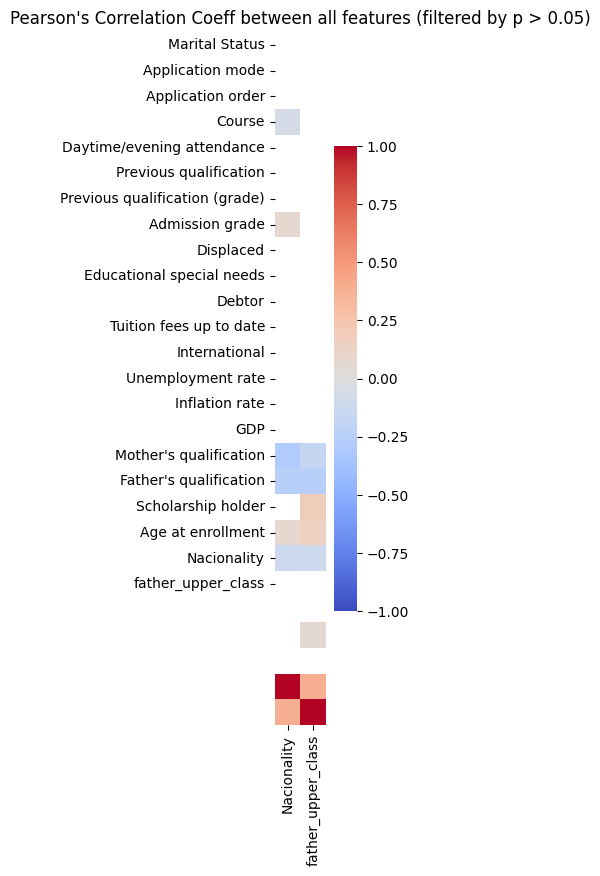

In [222]:
plot_corr(df_class, protected_features=True)